# Slow fast projections

Add doc with equations

Expentially decorrelated time series are generated with an order 1 ARMA process.

- arma statsmodel [doc](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.arma_generate_sample.html#statsmodels.tsa.arima_process.arma_generate_sample)
- arma on [wikipedia](https://en.wikipedia.org/wiki/Autoregressive–moving-average_model)

In [1]:
import itertools
import numpy as np
import xarray as xr
import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt

import sstats.tseries as ts
import sstats.filtering as fl
import sstats as ss

In [2]:
from dask.distributed import Client, LocalCluster

#
cluster = LocalCluster()
#
# from dask_jobqueue import PBSCluster
# cluster = PBSCluster()
# w = cluster.scale(28*1)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:52535 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


---

## generate synthetic data

In [34]:
# utils
time = (20, 1.0 / 24.0 / 2.0)
# time = (100, 1./24./2.)
draws = 10000


def exp(name, Td, Tw):
    ds = (
        ts.exp_autocorr(time, Td + Tw * 0.0, 1, draws=draws, name=name).rename(
            {"tau": "Td"}
        )
    ).to_dataset()
    ds["Td"] = Tw
    ds = ds.rename({"Td": "Tw"})
    return ds


def uniform(name, Tw):
    ds = (
        ts.uniform(time, low=Tw * 0.0, high=2 * np.pi, draws=draws, name=name)
    ).to_dataset()  # .rename({'tau':'Td'})
    ds["low"] = Tw
    ds = ds.rename({"low": "Tw"})
    return ds

In [35]:
# decorrelation time scales
# Tw = np.arange(0.25,20,.125)
Tw = np.arange(0.25, 2, 1 / 24)
Td = 5.0

A = {"slow": 1.0, "stationary": 1.0, "nonstationary": 1.0}

# slow:
ds = A["slow"] * exp("slow", Td, Tw)
# .to_dataset()
# ds['Td'] = T
# ds = ds.rename({'Td':'T'})

# fast:
omega = 2.0 * np.pi * 2.0

# stationary part
# phi = (ts.uniform(time,
#                  low=0.,
#                  high=2*np.pi,
#                  draws=draws,
#                  name='phi'
#                 )
#       .isel(time=0)
#       .persist() # persist is very important here !!
#      )
phi = (
    uniform("phi", Tw).phi.isel(time=0).persist()
)  # persist may be very important here !!
# phi = ds['x_s'].isel(time=-1)*100. # random phase from x_s
ds["stationary"] = A["stationary"] * np.cos(phi + omega * ds["time"]).persist()

# nonstationary part
x = exp("x", Td, Tw)["x"]
y = exp("y", Td, Tw)["y"]
ds["nonstationary"] = A["nonstationary"] * np.real(
    x * np.cos(omega * ds["time"]) + 1j * y * np.sin(omega * ds["time"])
)

# mask data to simulate different windows
ds = ds.where(ds.time >= ds.time.isel(time=-1) - ds.Tw)

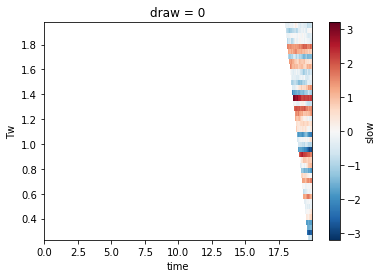

In [36]:
ds["slow"].sel(draw=0).plot()

### check variances

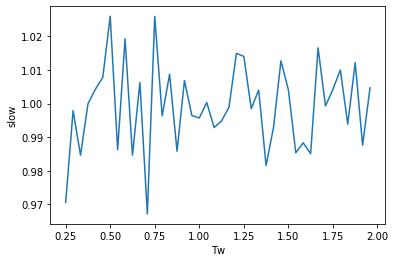

In [37]:
(ds["slow"] ** 2).mean(dim=["draw", "time"]).plot()

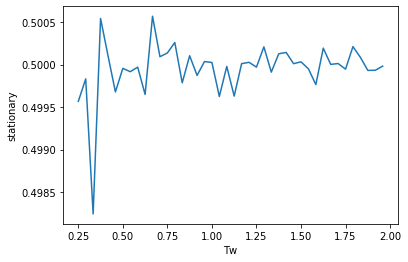

In [38]:
(ds["stationary"] ** 2).mean(dim=["draw", "time"]).plot()

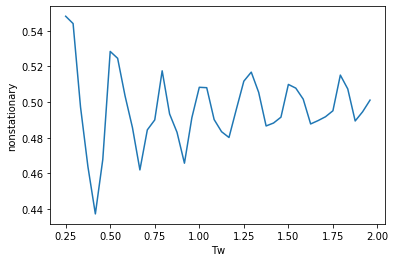

In [39]:
(ds["nonstationary"] ** 2).mean(dim=["draw", "time"]).plot()

### project on mean and harmonic parts

In [40]:
D = {
    omega: (abs((ds * np.exp(-1j * omega * ds.time)).mean("time")) ** 2)
    .mean("draw")
    .persist()
    for omega in [0, omega]
}

/Users/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)


In [42]:
# add theoretical curves
for _omega, d in D.items():
    d["slow_th"] = fl.analytical_variance_slow(Td, ds.Tw, _omega, std=A["slow"])
    d["stationary_th"] = fl.analytical_variance_stationary(
        omega + 1e-3, ds.Tw, _omega, std=A["stationary"]
    )
    d["nonstationary_th"] = fl.analytical_variance_nonstationary(
        Td, omega + 1e-3, ds.Tw, _omega, std=A["nonstationary"]
    )

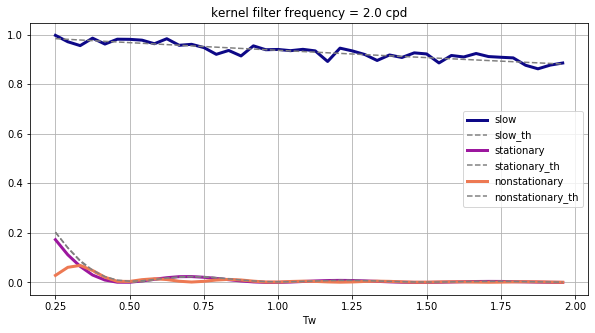

In [43]:
colors = ss.get_cmap_colors(len(ds))

d = D[0]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for v, c in zip(ds, colors):
    d[v].plot(ax=ax, lw=3, color=c, label=v)
    d[v + "_th"].plot(ax=ax, color="0.5", ls="--", label=v + "_th")
ax.set_title("kernel filter frequency = {} cpd".format(_omega / 2.0 / np.pi))
ax.legend()
ax.set_ylabel("")
ax.grid()
# ax.set_xscale("log")
# ax.set_yscale("log")

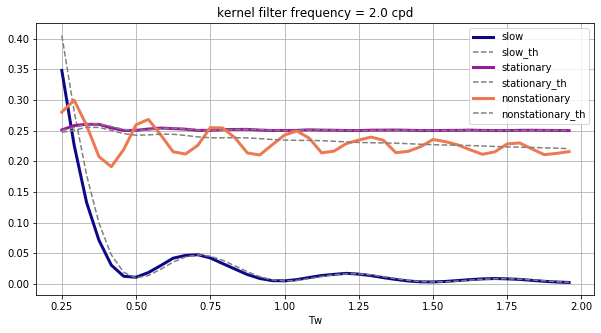

In [44]:
d = D[omega]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for v, c in zip(ds, colors):
    d[v].plot(ax=ax, lw=3, color=c, label=v)
    d[v + "_th"].plot(ax=ax, color="0.5", ls="--", label=v + "_th")
ax.set_title("kernel filter frequency = {} cpd".format(_omega / 2.0 / np.pi))
ax.legend()
ax.set_ylabel("")
ax.grid()
# ax.set_xscale("log")
# ax.set_yscale("log")

---

## old: generate synthetic data - vary decorrelation time scale

In [3]:
# utils
exp = lambda name, Td: (
    ts.exp_autocorr((100, 1.0 / 24.0), Td, 1, draws=2000, name=name).rename(
        {"tau": "Td"}
    )
)

# theoretical expectations
It = lambda T, omega: (
    2
    * (
        omega**2 * T
        + omega**2
        + T
        + (
            -(omega**2) * np.cos(omega * T)
            - 2 * omega * np.sin(omega * T)
            + np.cos(omega * T)
        )
        * np.exp(-T)
        - 1
    )
    / (T**2 * (omega**4 + 2 * omega**2 + 1))
)
Ip = lambda T, omega, omega0: (It(T, omega - omega0) + It(T, omega + omega0)) / 2.0

In [4]:
# decorrelation time scales
T = np.arange(1, 30, 1)

# slow:
ds = exp("x_s", T).to_dataset()

# fast:
omega = 2.0 * np.pi * 2.0
x = exp("x", T)
y = exp("y", T)
ds["x_p"] = np.real(
    x * np.cos(omega * ds["time"]) + 1j * y * np.sin(omega * ds["time"])
)

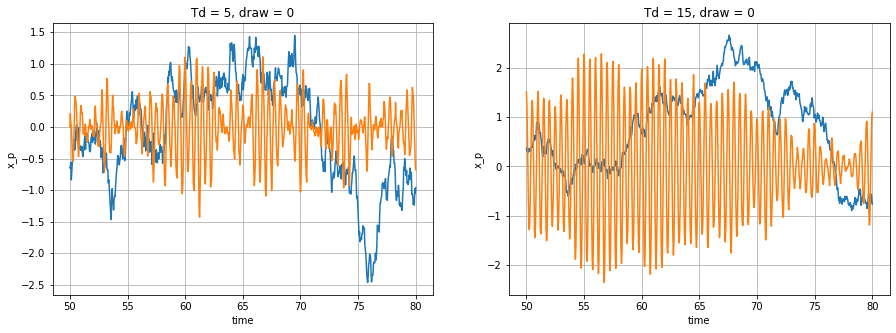

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for Td, ax in zip([5, 15], axs):
    _ds = ds.sel(draw=0, Td=Td, time=slice(50, 80))
    _ds["x_s"].plot(ax=ax)
    _ds["x_p"].plot(ax=ax)
    ax.grid()

In [6]:
# check variances of signals
print("mean slow variance = {:.2f}".format(ds["x_s"].std().values))
print("mean periodic variance = {:.2f}".format(ds["x_p"].std().values))

mean slow variance = 0.96
mean periodic variance = 0.68


### project on mean and harmonic parts

In [7]:
proj = (
    lambda da, omega, tslice: (da * np.exp(-1j * omega * da.time))
    .sel(time=tslice)
    .mean("time")
)

T = [2, 10, 20]

D = {}
for _T in T:
    tslice = slice(50, 50 + _T)
    _p = xr.merge(
        [proj(ds[v], 0.0, tslice).rename(v + "_mean") for v in ["x_s", "x_p"]]
        + [proj(ds[v], omega, tslice).rename(v + "_omega") for v in ["x_s", "x_p"]]
    )

    _D = np.sqrt((np.abs(_p) ** 2).mean("draw"))
    _Td = _D.Td
    _D["x_s_mean_th"] = np.sqrt(It(_T / _Td, 0.0))
    _D["x_s_omega_th"] = np.sqrt(It(_T / _Td, omega * _Td))
    _D["x_p_mean_th"] = np.sqrt(Ip(_T / _Td, 0.0, omega * _Td) / 2.0)  # tmp rescaling
    _D["x_p_omega_th"] = np.sqrt(
        Ip(_T / _Td, omega * _Td, omega * _Td) / 2.0
    )  # tmp rescaling
    D[_T] = _D.persist()

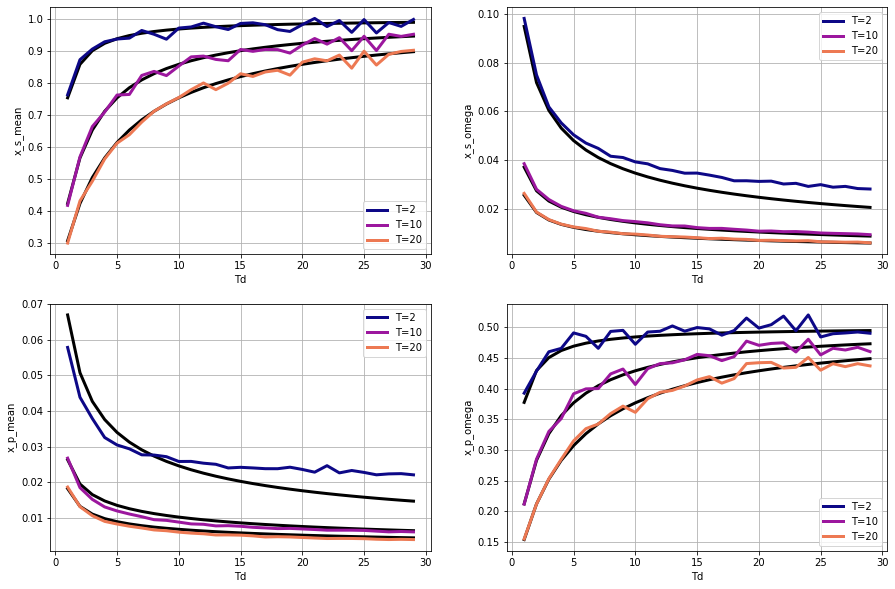

In [8]:
colors = ss.get_cmap_colors(len(D))

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for v, ax in zip(itertools.product(["x_s", "x_p"], ["_mean", "_omega"]), axs.flatten()):
    _v = "".join(v)
    for _T, c in zip(D, colors):
        D[_T][_v + "_th"].plot(ax=ax, color="k", lw=3)
        D[_T][_v].plot(ax=ax, color=c, lw=3, label="T={}".format(_T))
        ax.grid()
    ax.legend()